In [13]:
import numpy as np
import torch
import torch.nn as nn
import fastai.basics as fs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [14]:
torch.cuda.current_device()

0

In [15]:
path = 'data/'
filename = 'collar-sample-data.npz'
npfile=np.load(path+filename)

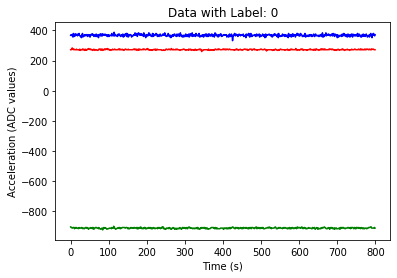

In [16]:
# load the raw data (in this case 3 axis acceleration data)
X=npfile['arr_0']

# load the labels for the raw data
Y=npfile['arr_1']

# now let's create a plot figure, add some axis and title labels and finally plot the 3 different acceleration values
ax1 = plt.subplot(111)
ax1.set_title("Data with Label: {}".format(Y[1]))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (ADC values)")
ax1.plot(X[1][0], color='red')
ax1.plot(X[1][1], color='green')
ax1.plot(X[1][2], color='blue');

In [17]:
nchannels = 3
nfilters = 64
# number_of_points = 850

# define CNN model layers

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

model = nn.Sequential(
    # Layer 1
    nn.Conv1d(in_channels=nchannels, out_channels=nfilters, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.BatchNorm1d(nfilters),
    # Layer 2
    nn.Conv1d(in_channels=nfilters, out_channels=nfilters, kernel_size=8, stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(nfilters),
    # Layer 3
    nn.Conv1d(in_channels=nfilters, out_channels=nfilters, kernel_size=16, stride=2),
    nn.ReLU(),
    nn.BatchNorm1d(nfilters),
    # Flat
    Flatten(),
    nn.Linear(12160, 3),
    nn.Softmax(dim=1))

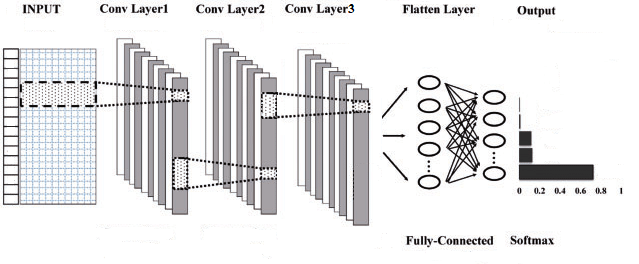

In [18]:
X=npfile['arr_0']
Y=npfile['arr_1']
Y=Y.squeeze()
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)
x_train,y_train,x_valid,y_valid = map(torch.tensor, (X_train,Y_train,X_valid,Y_valid))
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

torch.Size([3443, 3, 800]) torch.Size([3443]) torch.Size([1697, 3, 800]) torch.Size([1697])


In [19]:
bs = 256
train_ds = fs.TensorDataset(x_train.float(), y_train)
valid_ds = fs.TensorDataset(x_valid.float(), y_valid)
data = fs.DataBunch.create(train_ds, valid_ds, bs=bs) #fastai function
average_type = 'macro'
learn = fs.Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=fs.FBeta(average=average_type, beta=1),callback_fns=fs.ShowGraph)
print(sum(p.numel() for p in model.parameters()))

136131


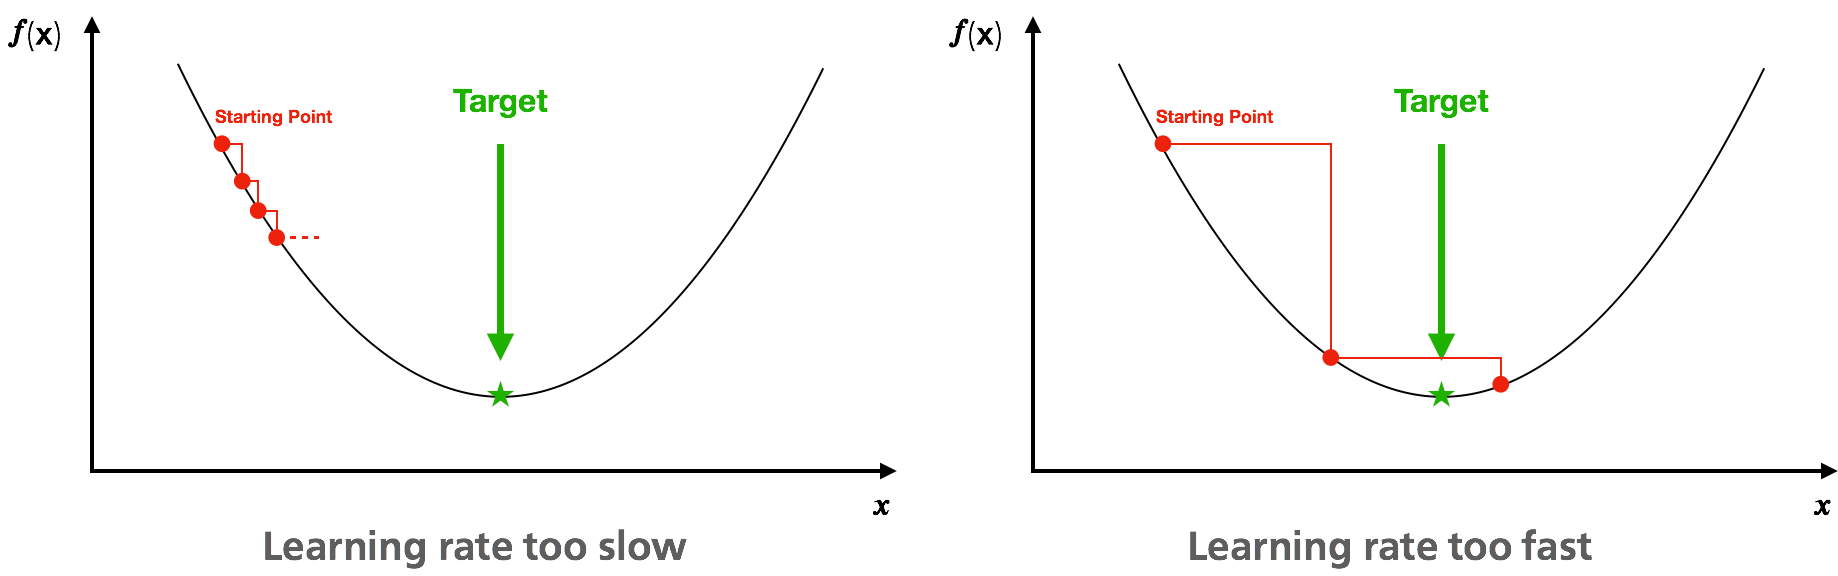

Source: https://www.wandb.com/tutorial/build-a-neural-network

In [20]:
# use lr_find find to use cyclical learning rates to automatically find learning rate

learn.lr_find(start_lr=1e-12, end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


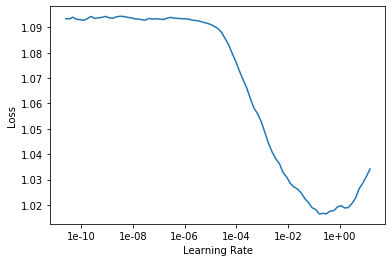

In [21]:
# plot the results of lr_find to allow the selection of the 

learn.recorder.plot()

epoch,train_loss,valid_loss,f_beta,time
0,1.092374,1.087108,0.307163,00:01
1,1.089397,1.084649,0.341590,00:01
2,1.087254,1.080069,0.417978,00:01
3,1.083418,1.073771,0.455730,00:01
4,1.079634,1.067589,0.479765,00:01
5,1.075047,1.059647,0.495817,00:01
6,1.069950,1.051897,0.517821,00:01
7,1.064051,1.042385,0.526271,00:01
8,1.057324,1.032223,0.531369,00:01
9,1.049705,1.022079,0.534593,00:01


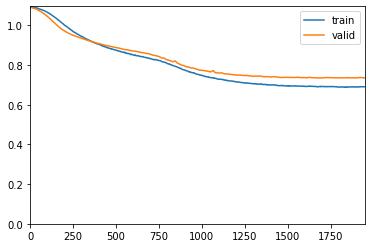

In [22]:
# set how many

num_epochs = 150
learn.fit_one_cycle(num_epochs, max_lr=1e-5)

Text(0, 0.5, 'F1 score')

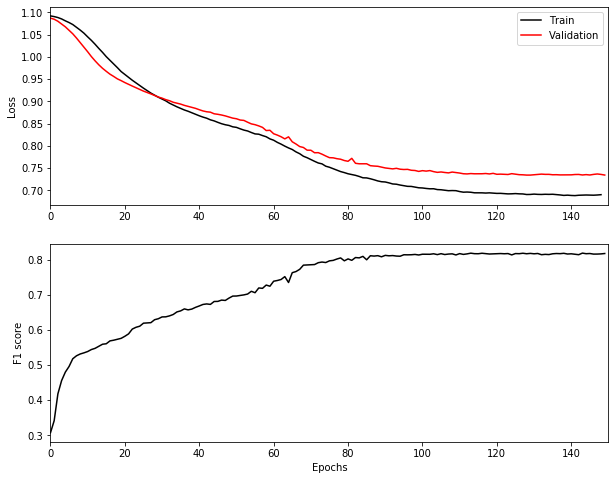

In [23]:
losses = learn.recorder.losses
val_losses = learn.recorder.val_losses
metrics = learn.recorder.metrics
nb_batches = learn.recorder.nb_batches

l = []
vec = np.arange(0,len(losses),nb_batches[0])
for i in range(len(vec)-1):
    l = l + [np.mean(losses[vec[i]:vec[i+1]])]

fs.plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.plot(l, color = 'k')
ax1.plot(val_losses, color = 'r')
ax1.set_xlim([0, num_epochs])
ax1.set_title('')
ax1.set_ylabel('Loss')
ax1.legend(['Train','Validation'])

ax2.plot(metrics, color = 'k')
ax2.set_xlim([0, num_epochs])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 score')

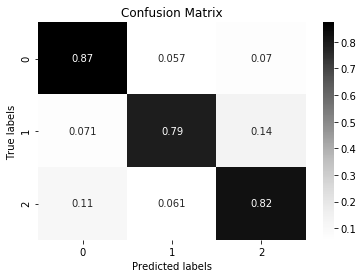

In [24]:
y_pred_prob,y_true= learn.get_preds()
y_pred = np.argmax(y_pred_prob.numpy(),axis=1)
y_true = np.array(y_true)
classes_txt = ['0', '1', '2']
classes = np.take(classes_txt,[0,1,2])
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greys'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes_txt); ax.yaxis.set_ticklabels(classes_txt);